Epoch 0: L_pde=2.591e-06, L_comp=3.461e-05, L_vol=7.389e-03
Epoch 200: L_pde=3.448e-06, L_comp=1.735e-05, L_vol=6.354e-03
Epoch 400: L_pde=4.415e-06, L_comp=2.077e-05, L_vol=1.056e-02
Epoch 600: L_pde=3.979e-06, L_comp=2.096e-05, L_vol=1.078e-02
Epoch 800: L_pde=5.503e-06, L_comp=2.517e-05, L_vol=2.031e-02
Epoch 1000: L_pde=4.263e-06, L_comp=2.282e-05, L_vol=1.422e-02
Epoch 1200: L_pde=4.933e-06, L_comp=2.560e-05, L_vol=2.220e-02
Epoch 1400: L_pde=4.802e-06, L_comp=2.356e-05, L_vol=1.563e-02
Epoch 1600: L_pde=4.801e-06, L_comp=2.640e-05, L_vol=2.228e-02
Epoch 1800: L_pde=6.430e-06, L_comp=3.040e-05, L_vol=2.142e-02
Epoch 2000: L_pde=9.511e-06, L_comp=2.595e-05, L_vol=2.315e-02
Epoch 2200: L_pde=5.614e-06, L_comp=2.650e-05, L_vol=2.559e-02
Epoch 2400: L_pde=1.214e-05, L_comp=2.740e-05, L_vol=2.084e-02
Epoch 2600: L_pde=6.977e-06, L_comp=2.449e-05, L_vol=1.879e-02
Epoch 2800: L_pde=1.080e-05, L_comp=2.698e-05, L_vol=2.818e-02
Epoch 3000: L_pde=6.389e-06, L_comp=2.797e-05, L_vol=2.858e-02

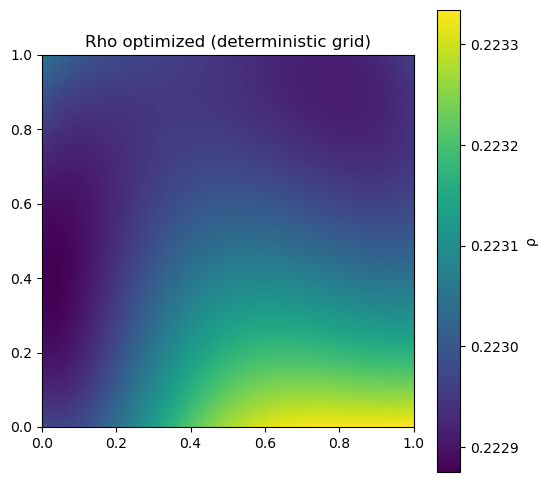

In [14]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------
# 1. Parámetros del problema
# --------------------------------------------------------
E0, Emin = 1.0, 1e-3
nu = 0.3
penal = 3.0
Vfrac = 0.4  # fracción de volumen deseada

w_pde = 1.0
w_bc = 10.0
w_neu = 10.0
w_comp = 500.0
w_vol = 1.0
w_smooth = 10.0

device = "cuda" if torch.cuda.is_available() else "cpu"

# Parámetros de la tracción puntual aproximada (perfil gaussiano en y)
P_total = 1.0
eps_trac = 0.05  # semiancho del perfil gaussiano

# --------------------------------------------------------
# 2. Red base (MLP)
# --------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden=64, layers=4):
        super().__init__()
        layers_list = [nn.Linear(in_dim, hidden), nn.Tanh()]
        for _ in range(layers - 1):
            layers_list += [nn.Linear(hidden, hidden), nn.Tanh()]
        layers_list.append(nn.Linear(hidden, out_dim))
        self.net = nn.Sequential(*layers_list)
    def forward(self, x):
        return self.net(x)

# Redes duales
u_net = MLP(2, 2).to(device)
rho_net = MLP(2, 1).to(device)

# --------------------------------------------------------
# 3. Funciones auxiliares (autodiff, tensiones, divergencia)
# --------------------------------------------------------
def grads(u, x):
    return autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]

def strain_from_disp(ux, uy, x):
    grad_ux = grads(ux, x)
    grad_uy = grads(uy, x)
    eps_xx = grad_ux[:, 0:1]
    eps_yy = grad_uy[:, 1:2]
    eps_xy = 0.5 * (grad_ux[:, 1:2] + grad_uy[:, 0:1])
    # devolvemos [eps_xx, eps_yy, eps_xy]
    return torch.cat([eps_xx, eps_yy, eps_xy], dim=1)

def stress_from_strain(eps, rho):
    # eps: [N,3], rho: [N,1]
    E = Emin + (E0 - Emin) * rho**penal  # [N,1]
    c1 = E / (1 - nu**2)
    c2 = nu * c1
    c3 = E / (2 * (1 + nu))
    sig_xx = c1 * eps[:, 0:1] + c2 * eps[:, 1:2]
    sig_yy = c2 * eps[:, 0:1] + c1 * eps[:, 1:2]
    sig_xy = c3 * eps[:, 2:3]
    return torch.cat([sig_xx, sig_yy, sig_xy], dim=1)

def div_stress(sig, x):
    sig_xx, sig_yy, sig_xy = sig[:, 0:1], sig[:, 1:2], sig[:, 2:3]
    grad_sig_xx = grads(sig_xx, x)
    grad_sig_yy = grads(sig_yy, x)
    grad_sig_xy = grads(sig_xy, x)
    divx = grad_sig_xx[:, 0:1] + grad_sig_xy[:, 1:2]
    divy = grad_sig_xy[:, 0:1] + grad_sig_yy[:, 1:2]
    return torch.cat([divx, divy], dim=1)

def smoothness(rho, x):
    grad_rho = grads(rho, x)   # [N,2]
    return (grad_rho**2).sum(1, keepdim=True)

# --------------------------------------------------------
# 4. Grid determinista (sin aleatoriedad)
# --------------------------------------------------------
# parámetros de la rejilla de entrenamiento (interior y fronteras)
nx_int, ny_int = 80, 80   # interior grid resolution
nx_b, ny_b = 1, 80        # boundary resolution (vertical)
nx_force, ny_force = 1, 121  # fuerza en borde derecho (más fino para mejor resolución)

# coordenadas en [0,1]x[0,1]
xs_int = np.linspace(0.0, 1.0, nx_int)
ys_int = np.linspace(0.0, 1.0, ny_int)
X_int, Y_int = np.meshgrid(xs_int, ys_int, indexing='xy')
pts_int = np.stack([X_int.flatten(), Y_int.flatten()], axis=1)  # determinista
pts_int = torch.tensor(pts_int, dtype=torch.float32, device=device).clone().detach().requires_grad_(True)

# frontera izquierda (x=0)
ys_b = np.linspace(0.0, 1.0, ny_b)
X_b = np.zeros_like(ys_b)
pts_left = np.stack([X_b, ys_b], axis=1)
pts_left = torch.tensor(pts_left, dtype=torch.float32, device=device).clone().detach().requires_grad_(True)

# frontera derecha (x=1) para imponer tracción determinista
ys_force = np.linspace(0.0, 1.0, ny_force)
X_f = np.ones_like(ys_force)
pts_right = np.stack([X_f, ys_force], axis=1)
pts_right = torch.tensor(pts_right, dtype=torch.float32, device=device).clone().detach().requires_grad_(True)

# perfil de tracción gaussiana en la frontera derecha (determinista)
yv = torch.tensor(ys_force, dtype=torch.float32, device=device).view(-1,1)  # [ny_force,1]
sigma_g = eps_trac * 0.5
gauss = torch.exp(-0.5 * ((yv - 0.5)/sigma_g)**2)  # [ny_force,1]
# normalizamos para que integral (aprox sum) sea P_total
factor = (gauss.sum() + 1e-12)
t_y = -P_total * (gauss / factor)  # tracción en y (negativa hacia abajo)
# tracción vector por punto: t = [0, t_y]
t_right = torch.cat([torch.zeros_like(t_y), t_y], dim=1)  # [ny_force,2]

# --------------------------------------------------------
# 5. Pérdidas deterministas (usando grids fijos)
# --------------------------------------------------------
def losses_on_grid():
    # puntos interiores ya definidos: pts_int (requires_grad True)
    x_int = pts_int
    u = u_net(x_int)
    ux, uy = u[:,0:1], u[:,1:2]
    # usamos rho detach para entrenar u_net (no actualizar rho_net)
    rho_det = torch.sigmoid(rho_net(x_int)).detach()
    eps = strain_from_disp(ux, uy, x_int)
    sig = stress_from_strain(eps, rho_det)
    divsig = div_stress(sig, x_int)
    L_pde = (divsig**2).mean()

    # BC en frontera izquierda: u = 0
    u_b = u_net(pts_left)
    L_bc = (u_b**2).mean()

    # Neumann (tracción) en frontera derecha: comparamos sigma.n con t_right
    # calcular eps y sigma en pts_right
    u_r = u_net(pts_right)
    ux_r, uy_r = u_r[:,0:1], u_r[:,1:2]
    eps_r = strain_from_disp(ux_r, uy_r, pts_right)
    sig_r = stress_from_strain(eps_r, torch.sigmoid(rho_net(pts_right)).detach())
    # n = (1,0) para borde derecho -> traction_pred = [sxx, sxy]
    traction_pred = torch.cat([sig_r[:,0:1], sig_r[:,2:3]], dim=1)
    # t_right is [0, t_y] (shape matches)
    L_neu = ((traction_pred - t_right)**2).mean()

    return L_pde, L_bc, L_neu

def losses_rho_on_grid():
    x_int = pts_int
    # calculamos u y eps sin no_grad (para poder computar eps), luego detach eps
    u = u_net(x_int)
    ux, uy = u[:,0:1], u[:,1:2]
    eps = strain_from_disp(ux, uy, x_int)
    eps_det = eps.detach()
    # rho (variable para rho_net)
    rho = torch.sigmoid(rho_net(x_int))
    sig = stress_from_strain(eps_det, rho)
    sig_e = (sig * eps_det).sum(dim=1, keepdim=True)
    L_comp = torch.mean((rho**penal) * sig_e)
    L_vol = (rho.mean() - Vfrac)**2
    L_smooth = smoothness(rho, x_int).mean()
    return L_comp, L_vol, L_smooth

# --------------------------------------------------------
# 6. Entrenamiento (alternado) usando grids fijos
# --------------------------------------------------------
opt_u = torch.optim.Adam(u_net.parameters(), lr=1e-3)
opt_rho = torch.optim.Adam(rho_net.parameters(), lr=1e-3)

epochs = 5000
for epoch in range(epochs):
    # --- actualizar u_net ---
    L_pde, L_bc, L_neu = losses_on_grid()
    loss_u = w_pde * L_pde + w_bc * L_bc + w_neu * L_neu
    opt_u.zero_grad()
    loss_u.backward()
    opt_u.step()

    # --- actualizar rho_net ---
    L_comp, L_vol, L_smooth = losses_rho_on_grid()
    loss_rho = w_comp * L_comp + w_vol * L_vol + w_smooth * L_smooth
    opt_rho.zero_grad()
    loss_rho.backward()
    opt_rho.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}: L_pde={L_pde.item():.3e}, L_comp={L_comp.item():.3e}, L_vol={L_vol.item():.3e}")

# --------------------------------------------------------
# 7. Visualización final (malla densa)
# --------------------------------------------------------
nx_vis, ny_vis = 120, 120
xs = np.linspace(0.0, 1.0, nx_vis)
ys = np.linspace(0.0, 1.0, ny_vis)
Xv, Yv = np.meshgrid(xs, ys, indexing='xy')
pts_vis = np.stack([Xv.flatten(), Yv.flatten()], axis=1)
pts_vis_t = torch.tensor(pts_vis, dtype=torch.float32, device=device)
rho_vis = torch.sigmoid(rho_net(pts_vis_t)).detach().cpu().numpy().reshape(nx_vis, ny_vis)

plt.figure(figsize=(6,6))
plt.imshow(rho_vis.T, origin='lower', extent=[0,1,0,1], cmap='viridis')
plt.colorbar(label='ρ')
plt.title("Rho optimized (deterministic grid)")
plt.show()
